# Synthesizing a Keras model with the weights of the ETX4VELO MLP

This is a toy implementation, the generated firmware is far from optimised.

## Importing the ETX4VELO MLP from PyTorch

In [1]:
import torch
import numpy as np

In [2]:
import sys
sys.path.append('etx4velo/LHCb_Pipeline') # etx4velo
# sys.path.append('hls4ml') # hls4ml, to use the local version

from Embedding.models.layerless_embedding import LayerlessEmbedding

embedding_artifact_path = "embedding_etx4velo.ckpt"

print(f"{embedding_artifact_path=}")

mlp = LayerlessEmbedding.load_from_checkpoint(
    embedding_artifact_path,
    # map_location="cpu",
    # If importing model from another experiment
    # hparams=load_config(CONFIG)["metric_learning"],
)


embedding_artifact_path='embedding_etx4velo.ckpt'


In [3]:
mlp

LayerlessEmbedding(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=4, bias=True)
  )
)

## Saving the weights and biases of the PyTorch model in a dictionary

In [4]:
d = {}
for name, parameter in mlp.named_parameters():
    print(name)
    print(parameter)
    print(parameter.shape)
    d[name] = parameter.detach().numpy().transpose()

network.0.weight
Parameter containing:
tensor([[-0.2593,  0.0883,  0.2114,  0.0421],
        [-0.4034, -0.1625,  0.1696,  0.3043],
        [-0.3941,  0.1123,  0.1119, -0.0640],
        ...,
        [ 0.4151,  0.4055,  0.0549,  0.4387],
        [-0.0862,  0.2769,  0.0369, -0.1426],
        [ 0.3235,  0.3090, -0.1603, -0.1579]], requires_grad=True)
torch.Size([256, 4])
network.0.bias
Parameter containing:
tensor([-0.1937,  0.2876, -0.3559,  0.3863, -0.2584, -0.1582, -0.1454,  0.2115,
        -0.1543, -0.3053, -0.1244,  0.3637, -0.1038, -0.2740, -0.5153, -0.0082,
        -0.1123,  0.2361,  0.4670, -0.1744, -0.1765,  0.2911,  0.1978, -0.0078,
         0.3651, -0.3588,  0.2274, -0.0080, -0.1216,  0.5041,  0.3266,  0.0788,
        -0.4018,  0.3940, -0.2036, -0.2839, -0.4053, -0.4855,  0.0708,  0.0228,
        -0.3564, -0.0124, -0.2787, -0.3314,  0.1152,  0.0328, -0.2072,  0.0110,
         0.2248, -0.1316, -0.0111,  0.4086,  0.4842, -0.3357, -0.1058, -0.4814,
         0.1677,  0.1658, -0.3242

Parameter containing:
tensor([[ 0.0016,  0.0497,  0.0097,  ...,  0.0232, -0.0364, -0.0081],
        [-0.0119, -0.0366, -0.0478,  ...,  0.0309, -0.0321,  0.0382],
        [-0.0448, -0.0460,  0.0466,  ..., -0.0318,  0.0635,  0.0373],
        [-0.0104, -0.0038, -0.0117,  ...,  0.0525,  0.0598, -0.0390]],
       requires_grad=True)
torch.Size([4, 256])
network.8.bias
Parameter containing:
tensor([-0.0592, -0.0267,  0.0505, -0.0429], requires_grad=True)
torch.Size([4])


In [5]:
d['network.0.weight'].shape

(4, 256)

## Creating the Keras model

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation

# Create a Sequential model
mlp_keras = Sequential()

# Add layers to the model
mlp_keras.add(Dense(256, input_dim=4))  # Layer 0
mlp_keras.add(Activation('relu'))       # Layer 1

mlp_keras.add(Dense(256))               # Layer 2
mlp_keras.add(Activation('relu'))       # Layer 3

mlp_keras.add(Dense(256))               # Layer 4
mlp_keras.add(Activation('relu'))       # Layer 5

mlp_keras.add(Dense(256))               # Layer 6
mlp_keras.add(Activation('relu'))       # Layer 7

mlp_keras.add(Dense(4))                 # Layer 8

# Print the model summary
mlp_keras.summary()


2024-01-16 20:30:25.809706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280      
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               6

2024-01-16 20:30:27.823931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setting the weights of the initialized Keras model equal to the PyTorch model weights

In [7]:
for i in range(0, 10, 2):
    mlp_keras.layers[i].set_weights([d[f"network.{i}.weight"], d[f"network.{i}.bias"]])

## Verifying that the two models are exactly the same

In [8]:
# Keras
mlp_keras.predict([[0,1,0,0]])

1/1 [==============================] - 0s 137ms/step


array([[-0.15028329, -0.00232619,  0.04386256, -0.11972013]],
      dtype=float32)

In [9]:
# PyTorch
mlp.eval()
mlp(torch.tensor([0.,1,0,0]))

tensor([-0.1503, -0.0023,  0.0439, -0.1197], grad_fn=<ViewBackward0>)

In [10]:
test = np.random.randn(10, 4)
test = [test[i].tolist() for i in range(len(test))]

In [11]:
for i in test:
    print(np.allclose(mlp_keras.predict([i]), mlp(torch.tensor(i)).detach().numpy()))

1/1 [==============================] - 0s 119ms/step
True
1/1 [==============================] - 0s 51ms/step
True
1/1 [==============================] - 0s 45ms/step
True
1/1 [==============================] - 0s 35ms/step
True
1/1 [==============================] - 0s 36ms/step
True
1/1 [==============================] - 0s 37ms/step
True
1/1 [==============================] - 0s 49ms/step
True
1/1 [==============================] - 0s 37ms/step
True
1/1 [==============================] - 0s 52ms/step
True
1/1 [==============================] - 0s 51ms/step
True


## Creating the config for hls4ml

In [12]:
import hls4ml
import plotting

In [13]:
config = hls4ml.utils.config_from_keras_model(mlp_keras, granularity='name', default_precision='fixed<32,4>')
config['Model']['ReuseFactor'] = 1024
config['Model']['Strategy'] = 'Resource'

for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
    
# config['LayerName']['dense']['Precision']['weight'] = 'ap_fixed<17,4>'
# # config['LayerName']['dense']['Precision']['result'] = 'ap_fixed<17,4>'  

# config['LayerName']['dense_1']['Precision']['weight'] = 'ap_fixed<26,4>' 
# config['LayerName']['dense_1']['Precision']['result'] = 'ap_fixed<26,4>'

# config['LayerName']['activation_1']['Precision']['result'] = 'ap_fixed<26,4>'
    
# config['LayerName']['dense_2']['Precision']['weight'] = 'ap_fixed<25,4>'
# config['LayerName']['dense_2']['Precision']['result'] = 'ap_fixed<23,4>'

# config['LayerName']['activation_2']['Precision']['result'] = 'ap_fixed<23,4>'
    
# config['LayerName']['dense_3']['Precision']['weight'] = 'ap_fixed<32,4>'
# config['LayerName']['dense_3']['Precision']['bias'] = 'ap_fixed<32,4>'
# config['LayerName']['dense_3']['Precision']['result'] = 'ap_fixed<32,4>'


# config['LayerName']['dense_4']['Precision']['weight'] = 'ap_fixed<18,4>'
# config['LayerName']['dense_4']['Precision']['result'] = 'ap_fixed<18,4>'

print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: InputLayer, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: dense, layer type: Dense, input shapes: [[None, 4]], output shape: [None, 256]
Layer name: activation, layer type: Activation, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: activation_1, layer type: Activation, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: dense_2, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: activation_2, layer type: Activation, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: dense_3, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: activation_3, layer type: Activation, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 256]], out

## Creating the HLS project

In [14]:
hls_model = hls4ml.converters.convert_from_keras_model(
    mlp_keras, hls_config=config, output_dir='mlp/hls4ml_prj', part='xcu250-figd2104-2L-e',
)

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: InputLayer, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: dense, layer type: Dense, input shapes: [[None, 4]], output shape: [None, 256]
Layer name: activation, layer type: Activation, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: activation_1, layer type: Activation, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: dense_2, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: activation_2, layer type: Activation, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: dense_3, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: activation_3, layer type: Activation, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 256]], out

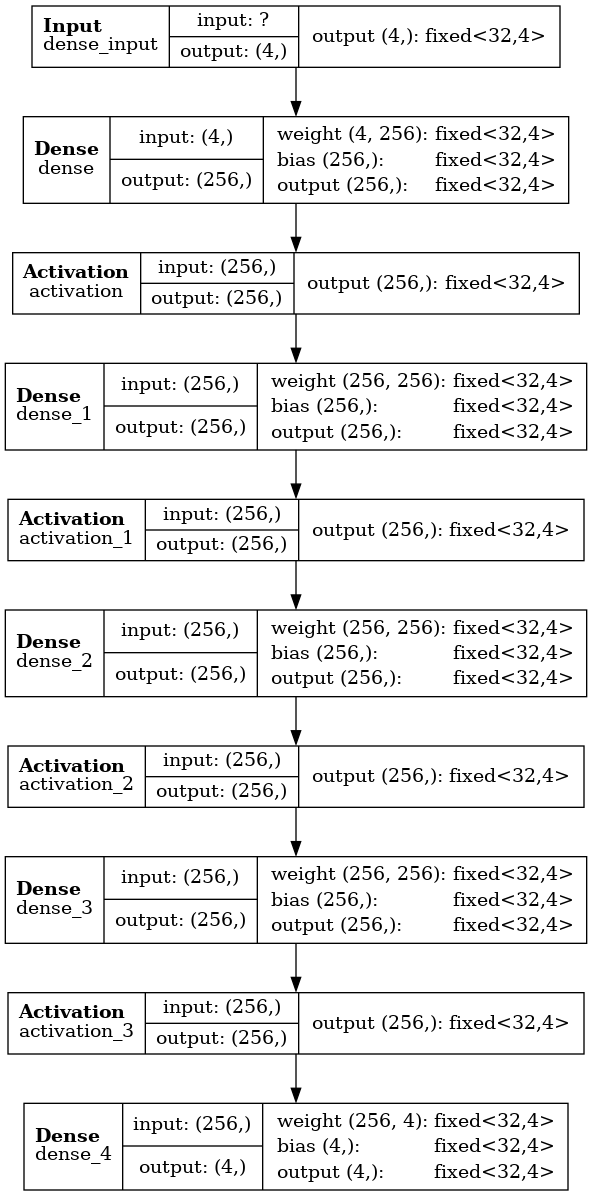

In [15]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Profiling

[hls4ml documentation](https://fastmachinelearning.org/hls4ml/api/profiling.html)

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: InputLayer, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: dense, layer type: Dense, input shapes: [[None, 4]], output shape: [None, 256]
Layer name: activation, layer type: Activation, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: activation_1, layer type: Activation, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: dense_2, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: activation_2, layer type: Activation, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: dense_3, layer type: Dense, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: activation_3, layer type: Activation, input shapes: [[None, 256]], output shape: [None, 256]
Layer name: dense_4, layer type: Dense, input shapes: [[None, 256]], out

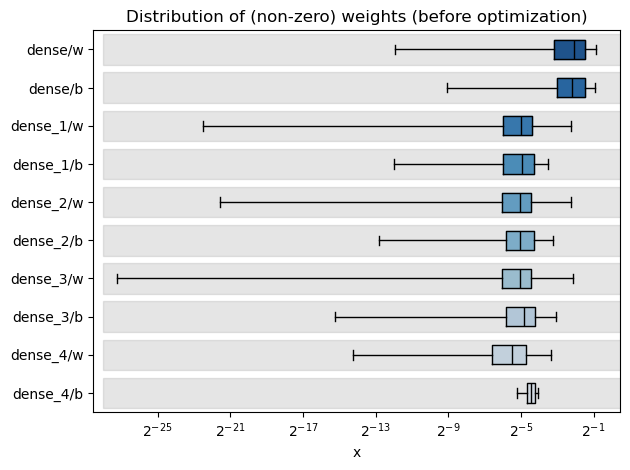

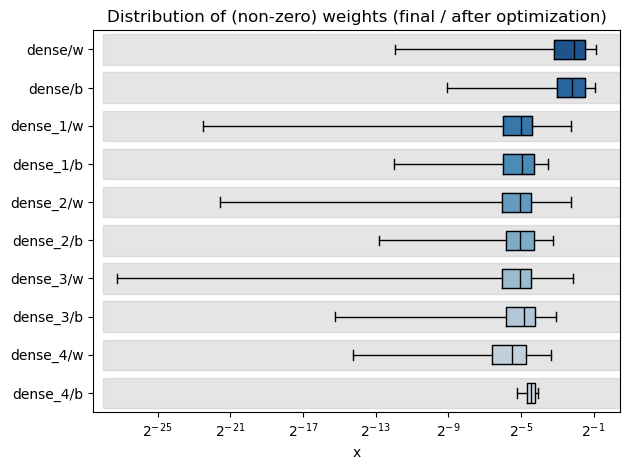

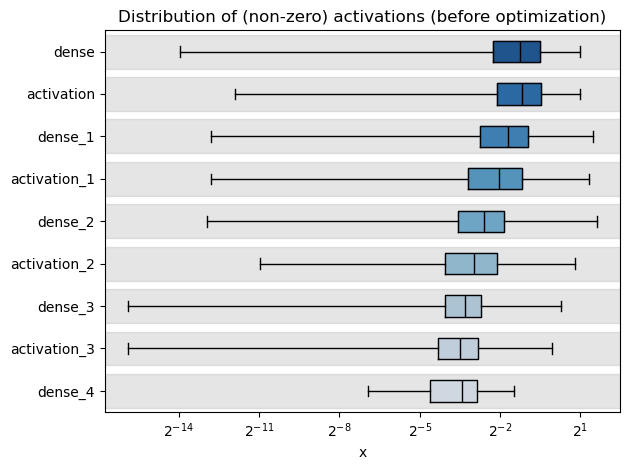

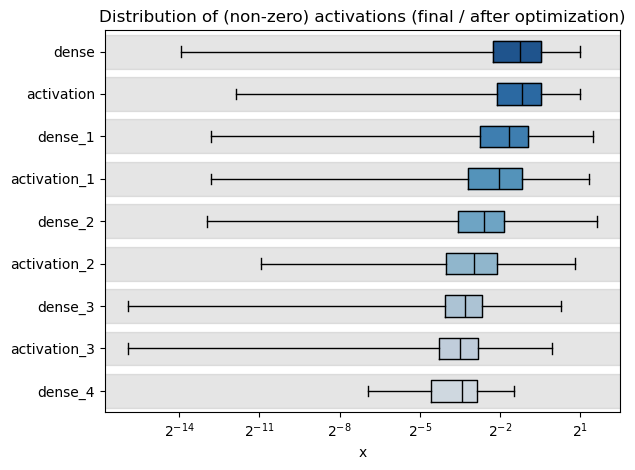

In [16]:
from hls4ml.model.profiling import numerical
from hls4ml.converters import keras_to_hls
import matplotlib.pyplot as plt
import yaml

# produce 4 plots
plots = numerical(model=mlp_keras, hls_model=hls_model, X=test)
plt.show()

## Compiling the HLS project

In [17]:
hls_model.compile()

Writing HLS project
Done


## Verifying the output model

In [18]:
test = np.random.randn(10, 4)

In [19]:
hls_model.predict(test)

array([[-0.10169017, -0.03215507,  0.06622146, -0.06239718],
       [-0.12769048,  0.10335595,  0.28659916, -0.0611782 ],
       [-0.13447774, -0.16553036,  0.04884099, -0.08547528],
       [-0.10803359,  0.04538561,  0.26940373, -0.05496877],
       [-0.11100496,  0.09404057,  0.2277771 , -0.05710308],
       [-0.17840401,  0.0985022 ,  0.27923038, -0.06022152],
       [-0.17159965,  0.01040218,  0.12581919, -0.032589  ],
       [-0.10204262,  0.05033289,  0.15964933, -0.15405588],
       [-0.07647497,  0.08744384,  0.18458185, -0.11224992],
       [-0.08637616,  0.07560976,  0.18586209, -0.12082608]])

In [20]:
x = np.array([[0.,.01,0.,0.]])

In [21]:
mlp_keras.predict(test)

1/1 [==============================] - 0s 20ms/step


array([[-0.10169017, -0.03215483,  0.06622174, -0.06239709],
       [-0.12769043,  0.10335633,  0.28659967, -0.06117797],
       [-0.13447775, -0.16553025,  0.04884122, -0.08547521],
       [-0.10803352,  0.04538595,  0.2694042 , -0.05496858],
       [-0.11100492,  0.09404105,  0.22777759, -0.05710288],
       [-0.17840403,  0.0985025 ,  0.27923083, -0.06022143],
       [-0.17159969,  0.01040245,  0.1258195 , -0.03258889],
       [-0.10204256,  0.05033321,  0.15964974, -0.1540558 ],
       [-0.07647491,  0.08744423,  0.1845823 , -0.11224982],
       [-0.08637608,  0.0756101 ,  0.18586253, -0.12082598]],
      dtype=float32)

In [22]:
# mlp(torch.tensor(test, dtype=torch.float32))

In [23]:
np.allclose(mlp_keras.predict(test), hls_model.predict(test), rtol=0.0001)

1/1 [==============================] - 0s 28ms/step


True

## Building and running the HLS project

In [24]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /users/soft/xilinx/2019.1/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/users/soft/xilinx/2019.1/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'fgias' on host 'bop' (Linux_x86_64 version 3.10.0-1160.62.1.el7.x86_64) on Tue Jan 16 20:35:32 CET 2024
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/users/cao/fgias/hls4ml-etx4velo/mlp/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/users/cao/fgias/hls4ml-etx4velo/mlp/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:13:31 ; elapsed = 00:13:46 . Memory (MB): peak = 1738.738 ; gain = 944.012 ; free physical = 12065 ; free virtual = 297676
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:13:45 ; elapsed = 00:14:00 . Memory (MB): peak = 1850.746 ; gain = 1056.020 ; free physical = 11971 ; free virtual = 297582
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<32, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<32, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, relu_config13>' (firmware/nnet_utils/nnet_activation.h:40:43).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:129) in function 'nnet::dense_resource<ap_fixed<32, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<32, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>' for pipelining.
INFO: [XFORM 203-502] Unrolling all loops for p

INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:104) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b14.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:104) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b11.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:104) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b8.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:104) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b5.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:104) in dimension 1 completely.
INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:17:31 ; elapsed = 00:17:49 . Memory (MB): peak = 2843.742 ; gain = 2049.016 ; free physical = 10960 ; free virtual = 296569
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_resource_ap_fixed_32_4_5_3_0_ap_fixed_32_4_5_3_0_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReuseLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 3.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 2737.71 seconds; current allocated memory: 1.796 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis

INFO: [HLS 200-111]  Elapsed time: 9.69 seconds; current allocated memory: 2.080 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 5.62 seconds; current allocated memory: 2.086 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_resource_ap_fixed_32_4_5_3_0_ap_fixed_32_4_5_3_0_config11_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReuseLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 3.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 45.42 seconds; current allocate

INFO: [RTGEN 206-104] Estimated max fanout for 'relu_ap_fixed_32_4_5_3_0_ap_fixed_32_4_5_3_0_relu_config10_s' is 16643 from HDL expression: (~((ap_start == 1'b0) | (ap_done_reg == 1'b1)) & (1'b1 == ap_CS_fsm_state1))
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_32_4_5_3_0_ap_fixed_32_4_5_3_0_relu_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 22.26 seconds; current allocated memory: 314.766 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_resource_ap_fixed_32_4_5_3_0_ap_fixed_32_4_5_3_0_config11_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-104] Estimated max fanout for 'dense_resource_ap_fixed_32_4_5_3_0_ap_fixed_32_4_5_3_0_config11_s' is 16386 from HDL expression: ((1'b0 == ap_block_pp0_stage0_11001) & (icmp_ln129_reg_55363_pp0_iter1_reg == 1'd1) & (ap_enable_reg_pp0_iter2 == 1'b1))
INFO: [RTGEN 206-100] Gene

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_39_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_40_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_41_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_42_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_43_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_44_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_45_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_46_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_47_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_48_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_126_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_127_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_128_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_129_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_130_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_131_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_132_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_133_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_134_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_135_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_212_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_213_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_214_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_215_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_216_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_217_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_218_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_219_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_220_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_221_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_41_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_42_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_43_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_44_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_45_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_46_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_47_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_48_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_49_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_50_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_129_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_130_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_131_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_132_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_133_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_134_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_135_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_136_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_137_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_138_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_213_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_214_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_215_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_216_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_217_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_218_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_219_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_220_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_221_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_222_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_42_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_43_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_44_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_45_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_46_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_47_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_48_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_49_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_50_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_51_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_129_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_130_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_131_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_132_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_133_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_134_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_135_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_136_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_137_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_138_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_214_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_215_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_216_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_217_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_218_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_219_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_220_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_221_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_222_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_223_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_43_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_44_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_45_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_46_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_47_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_48_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_49_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_50_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_51_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_52_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_129_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_130_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_131_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_132_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_133_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_134_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_135_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_136_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_137_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_138_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_214_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_215_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_216_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_217_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_218_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_219_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_220_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_221_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_222_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_223_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_44_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_45_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_46_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_47_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_48_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_49_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_50_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_51_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_52_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_53_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_129_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_130_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_131_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_132_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_133_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_134_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_135_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_136_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_137_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_138_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_214_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_215_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_216_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_217_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_218_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_219_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_220_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_221_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_222_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_223_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_42_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_43_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_44_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_45_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_46_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_47_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_48_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_49_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_50_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_51_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_126_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_127_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_128_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_129_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_130_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_131_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_132_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_133_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_134_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_135_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTM

INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_210_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_211_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_212_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_213_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_214_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_215_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_216_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_217_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_218_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer10_out_219_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTM

INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_38_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_39_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_40_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_41_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_42_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_43_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_44_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_45_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_46_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_47_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_122_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_123_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_124_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_125_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_126_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_127_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_128_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_129_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_130_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_131_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTM

INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_205_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_206_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_207_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_208_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_209_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_210_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_211_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_212_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_213_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_214_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTM

INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_34_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_35_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_36_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_37_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_38_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_39_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_40_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_41_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_42_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_43_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_119_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_120_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_121_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_122_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_123_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_124_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_125_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_126_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_127_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_128_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTM

INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_202_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_203_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_204_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_205_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_206_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_207_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_208_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_209_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_210_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_211_V_U(fifo_w32_d2_A)' using Shift Registers.
INFO: [RTM

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.328',
  'BestLatency': '5133',
  'WorstLatency': '5138',
  'IntervalMin': '1024',
  'IntervalMax': '1024',
  'BRAM_18K': '351',
  'DSP': '768',
  'FF': '190396',
  'LUT': '274041',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}